# Pygrid - MNIST Training (Domain-User)
In this notebook, we'll be showing how to perform a Remote training with MNIST dataset using PyGrid/PySyft 0.3.0.

**Author**: Ionésio Junior **Github**: [@IonesioJunior](https://github.com/IonesioJunior)    
**Author**: Madhava Jay **Github**: [@madhavajay](https://github.com/madhavajay)    
**Author**: Tudor Cebere **Github**: [@tudorcebere](https://github.com/tudorcebere)    

In [1]:
from syft.grid.grid_client import connect
from syft.grid.connections.http_connection import HTTPConnection
from syft.core.node.domain.client import DomainClient

import syft as sy
import torch as th
import torchvision as tv

sy.VERBOSE = False

In [2]:
client = connect(
    url="http://localhost:5000", # Domain Address
    credentials= {"email": "user@email.com", "password": "pwd123"}, # Admin role
    conn_type= HTTPConnection, # HTTP Connection Protocol
    client_type=DomainClient) # Domain Client type

### 3 - Retrieve some domain setting attributes

In [3]:
# lets get some references to our data owners Duet torch and torchvision
torch = client.torch
torchvision = client.torchvision

# these are the same as the original mnist example
transforms = torchvision.transforms
datasets = torchvision.datasets
nn = torch.nn
F = torch.nn.functional
optim = torch.optim
StepLR = torch.optim.lr_scheduler.StepLR

### Create local transforms for our local MNIST data

In [4]:
# we need some transforms for our MNIST data set
local_transform_1 = tv.transforms.ToTensor()  # this converts PIL images to Tensors
local_transform_2 = tv.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset

# compose our transforms
local_transforms = tv.transforms.Compose([local_transform_1, local_transform_2])

### Define Training settings

In [5]:
# Training settings from original MNIST example command line args
args = {
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 14,
    "lr": 1.0,
    "gamma": 0.7,
    "no_cuda": False,
    "dry_run": False,
    "seed": 42, # the meaning of life
    "log_interval": 10,
    "save_model": False,
}

## Define our test data

In [6]:
test_kwargs = {
    "batch_size": args["test_batch_size"],
}

# this is our carefully curated test data which represents the goal of our problem domain
test_data = tv.datasets.MNIST('../data', train=False, download=True, transform=local_transforms)
test_loader = th.utils.data.DataLoader(test_data,**test_kwargs)

In [7]:
test_data_length = len(test_loader.dataset)

## Set Local / Remote Model Architecture

In [8]:
# lets define our SOTA model to train on the Domain's data
# note we subclass from sy.Module not nn.Module
fc1_scaling_factor = 0.25  # this can let us scale the fc1 layer down a bit
class SyNet(sy.Module):
    def __init__(self):
        super(SyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, int(64 * fc1_scaling_factor), 3, 1)  # keep fc1 size down
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(int(9216 * fc1_scaling_factor), 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
# note we subclass from sy.Module not nn.Module
# WARNING: be extra careful to use th. not the torch from domain here
class LocalSyNet(sy.Module):
    def __init__(self):
        super(LocalSyNet, self).__init__()
        self.conv1 = th.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = th.nn.Conv2d(32, int(64 * fc1_scaling_factor), 3, 1)
        self.dropout1 = th.nn.Dropout2d(0.25)
        self.dropout2 = th.nn.Dropout2d(0.5)
        self.fc1 = th.nn.Linear(int(9216 * fc1_scaling_factor), 128)
        self.fc2 = th.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = th.nn.functional.relu(x)
        x = self.conv2(x)
        x = th.nn.functional.relu(x)
        x = th.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = th.flatten(x, 1)
        x = self.fc1(x)
        x = th.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = th.nn.functional.log_softmax(x, dim=1)
        return output


In [10]:
# lets see if our Domain has CUDA
has_cuda = False
has_cuda_ptr = torch.cuda.is_available()
has_cuda = bool(has_cuda_ptr.get(
    request_block=True,
    request_name="cuda_is_available",
    reason="To run test and inference locally",
    timeout_secs=30,  # change to something slower
))
print(has_cuda)


> Waiting for Blocking Request
cuda_is_available: To run test and inference locally.
<UID:8f4ac16b-fb65-48c8-883b-67a12a226cec>

> INSIDE Request BLOCK 2.1457672119140625e-06 seconds False

> Blocking Request ACCEPTED
False


In [11]:
use_cuda = not args["no_cuda"] and has_cuda
torch.manual_seed(args["seed"])

device = torch.device("cuda" if use_cuda else "cpu")
print(f"DO device is {device.type.get()}")

DO device is cpu


In [12]:
model = SyNet()
print(len(model.modules))
print(model.modules)

6
OrderedDict([('conv1', <syft.proxy.torch.nn.Conv2dPointer object at 0x7fbd34d599a0>), ('conv2', <syft.proxy.torch.nn.Conv2dPointer object at 0x7fbdc1e952b0>), ('dropout1', <syft.proxy.torch.nn.Dropout2dPointer object at 0x7fbd34d59fd0>), ('dropout2', <syft.proxy.torch.nn.Dropout2dPointer object at 0x7fbd34d59c40>), ('fc1', <syft.proxy.torch.nn.LinearPointer object at 0x7fbd34d6d430>), ('fc2', <syft.proxy.torch.nn.LinearPointer object at 0x7fbd34d6d910>)])


In [13]:
local_model = LocalSyNet()
local_model.zero_layers()  # so we can confirm that the weight download works
local_model.debug_sum_layers()
print(local_model.modules)

> Layer conv1 sum(weight): 0.0
> Layer conv1 sum(bias): 0.0
> Layer conv2 sum(weight): 0.0
> Layer conv2 sum(bias): 0.0
> Layer fc1 sum(weight): 0.0
> Layer fc1 sum(bias): 0.0
> Layer fc2 sum(weight): 0.0
> Layer fc2 sum(bias): 0.0
OrderedDict([('conv1', Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))), ('conv2', Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))), ('dropout1', Dropout2d(p=0.25, inplace=False)), ('dropout2', Dropout2d(p=0.5, inplace=False)), ('fc1', Linear(in_features=2304, out_features=128, bias=True)), ('fc2', Linear(in_features=128, out_features=10, bias=True))])


In [14]:
# if we have CUDA lets send our model to the GPU
if has_cuda:
    model.cuda(device)
else:
    model.cpu()

## Set Optimizer

In [15]:
# lets get our parameters for optimization
# params_list required for remote list concatenation
params = model.parameters(params_list=client.syft.lib.python.List())
print(params, type(params))

<syft.proxy.syft.lib.python.ListPointer object at 0x7fbd34d59d60> <class 'syft.proxy.syft.lib.python.ListPointer'>


In [16]:
optimizer = optim.Adadelta(params, lr=args["lr"])
print(optimizer, type(optimizer))

<syft.proxy.torch.optim.AdadeltaPointer object at 0x7fbd34d59400> <class 'syft.proxy.torch.optim.AdadeltaPointer'>


In [17]:
scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
print(scheduler, type(scheduler))

<syft.proxy.torch.optim.lr_scheduler.StepLRPointer object at 0x7fbd34d6d400> <class 'syft.proxy.torch.optim.lr_scheduler.StepLRPointer'>


## Define / Execute Remote and Local Training routines

In [18]:
# now can define a simple training loop very similar to the original PyTorch MNIST example
@sy.logger.catch
def train(args, model, device, train_loader, optimizer, epoch, train_data_length):
    # + 0.5 lets us math.ceil without the import
    train_batches = round((train_data_length / args["batch_size"]) + 0.5)
#     train_batches = 100
    print(f"> Running train in {train_batches} batches")
    model.train()

    for batch_idx, data in enumerate(train_loader):
#         time.sleep(1)
        data_ptr, target_ptr = data[0], data[1]
        optimizer.zero_grad()
        output = model(data_ptr)
        loss = F.nll_loss(output, target_ptr)
        loss.backward()
        optimizer.step()
        loss_item = loss.item()
        train_loss = client.syft.lib.python.Float(0)
        train_loss += loss_item
        if batch_idx % args["log_interval"] == 0:
#             local_loss = loss_item.get(
#                 request_name="loss",
#                 reason="To evaluate training progress",
#                 request_block=True,
#                 timeout_secs=30
#             )
            local_loss = None
            if local_loss is not None:
                print("Train Epoch: {} {} {:.4}".format(epoch, batch_idx, local_loss))
            else:
                print("Train Epoch: {} {} ?".format(epoch, batch_idx))
            if args["dry_run"]:
                break
        if batch_idx >= train_batches - 1:
            print("batch_idx >= train_batches, breaking")
            break

In [19]:
# TODO replace with local inference and local test set
# the same for our test training loop except we will need to send our data over for inference
@sy.logger.catch
def test_local(model, remote_model, test_loader, test_data_length):
    # download remote model
    model.copy_remote_state(
        remote_model=remote_model,
        request_name="model_download",
        reason="test evaluation",
        timeout_secs=30
    )
    # visually check the weights have changed
    model.debug_sum_layers()
    # + 0.5 lets us math.ceil without the import
    test_batches = round((test_data_length / args["test_batch_size"]) + 0.5)
    print(f"> Running test_local in {test_batches} batches")
    model.eval()
    test_loss = 0.0
    correct = 0.0

    with th.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
#             time.sleep(1)
            output = model(data)
            iter_loss = th.nn.functional.nll_loss(output, target, reduction='sum').item()
            test_loss = test_loss + iter_loss
            pred = output.argmax(dim=1)
            total = pred.eq(target).sum().item()
            correct += total
            if args["dry_run"]:
                break
                
            if batch_idx >= test_batches - 1:
                print("batch_idx >= test_batches, breaking")
                break

    accuracy = correct / test_data_length
    print("Test Set Average Loss:", 100 * accuracy)

In [20]:
# we need some transforms for our MNIST data set
transform_1 = torchvision.transforms.ToTensor()  # this converts PIL images to Tensors
transform_2 = torchvision.transforms.Normalize(0.1307, 0.3081)  # this normalizes the dataset
print(type(transform_1), type(transform_2))

remote_list = client.syft.lib.python.List()
remote_list.append(transform_1)
remote_list.append(transform_2)

# compose our transforms
transforms = torchvision.transforms.Compose(remote_list)

# The DO has kindly let us initialise a DataLoader for their training set
train_kwargs = {
    "batch_size": args["batch_size"],
}
train_data_ptr = torchvision.datasets.MNIST('../data', train=True, download=True, transform=transforms)
print(train_data_ptr)
train_loader_ptr = torch.utils.data.DataLoader(train_data_ptr,**train_kwargs)
print(train_loader_ptr)

<class 'syft.proxy.torchvision.transforms.ToTensorPointer'> <class 'syft.proxy.torchvision.transforms.NormalizePointer'>


In [21]:
def get_train_length(train_data_ptr):
    train_length_ptr = train_data_ptr.__len__()
    train_data_length = train_length_ptr.get(
        request_block=True,
        request_name="train_size",
        reason="To write the training loop",
        timeout_secs=30,
    )
    return train_data_length

try:
    if train_data_length is None:
        train_data_length = get_train_length(train_data_ptr)
except NameError:
        train_data_length = get_train_length(train_data_ptr)

print(f"Training Dataset size is: {train_data_length}")


> Waiting for Blocking Request
train_size: To write the training loop.
<UID:1c6f7ab9-665a-4afb-a039-e127d62447ef>

> INSIDE Request BLOCK 7.152557373046875e-07 seconds False

> Blocking Request ACCEPTED
Training Dataset size is: 60000


In [22]:
%%time
import time

args["dry_run"] = False
sy.logger.trace("Start Training")
for epoch in range(1, args["epochs"] + 1):
    epoch_start = time.time()
    print(f"Epoch: {epoch}")
    train(args, model, device, train_loader_ptr, optimizer, epoch, train_data_length)
    test_local(local_model, model, test_loader, test_data_length)  # real local data and model
    scheduler.step()
    epoch_end = time.time()
    print(f"Epoch time: {int(epoch_end - epoch_start)} seconds")
    break
sy.logger.trace("Finish Training")

Epoch: 1
> Running train in 938 batches
Train Epoch: 1 0 ?
Train Epoch: 1 10 ?
Train Epoch: 1 20 ?
Train Epoch: 1 30 ?
Train Epoch: 1 40 ?
Train Epoch: 1 50 ?
Train Epoch: 1 60 ?
Train Epoch: 1 70 ?
Train Epoch: 1 80 ?
Train Epoch: 1 90 ?
Train Epoch: 1 100 ?
Train Epoch: 1 110 ?
Train Epoch: 1 120 ?
Train Epoch: 1 130 ?
Train Epoch: 1 140 ?
Train Epoch: 1 150 ?
Train Epoch: 1 160 ?
Train Epoch: 1 170 ?
Train Epoch: 1 180 ?
Train Epoch: 1 190 ?
Train Epoch: 1 200 ?
Train Epoch: 1 210 ?
Train Epoch: 1 220 ?
Train Epoch: 1 230 ?
Train Epoch: 1 240 ?
Train Epoch: 1 250 ?
Train Epoch: 1 260 ?
Train Epoch: 1 270 ?
Train Epoch: 1 280 ?
Train Epoch: 1 290 ?
Train Epoch: 1 300 ?
Train Epoch: 1 310 ?
Train Epoch: 1 320 ?
Train Epoch: 1 330 ?
Train Epoch: 1 340 ?
Train Epoch: 1 350 ?
Train Epoch: 1 360 ?
Train Epoch: 1 370 ?
Train Epoch: 1 380 ?
Train Epoch: 1 390 ?
Train Epoch: 1 400 ?
Train Epoch: 1 410 ?
Train Epoch: 1 420 ?
Train Epoch: 1 430 ?
Train Epoch: 1 440 ?
Train Epoch: 1 450 ?
Train

## Running Inferences

In [23]:
import matplotlib.pyplot as plt
def draw_image_and_label(image, label):
    fig = plt.figure()
    plt.tight_layout()
    plt.imshow(image, cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(label))
    
def prep_for_inference(image):
    image_batch = image.unsqueeze(0).unsqueeze(0)
    image_batch = image_batch * 1.0
    return image_batch

In [24]:
def classify_local(image):
    image_tensor = th.Tensor(prep_for_inference(image))
    print("1", type(image_tensor))
    output = local_model(image_tensor)
    print("2", type(output))
    preds = th.exp(output)
    print("3", type(preds))
    local_y = preds
    local_y = local_y.squeeze()
    pos = local_y == max(local_y)
    index = th.nonzero(pos, as_tuple=False)
    class_num = index.squeeze()
    return class_num, local_y

In [25]:
def classify(image):
    image_tensor_ptr = torch.Tensor(prep_for_inference(image))
    output = model(image_tensor_ptr)
    preds = torch.exp(output)
    preds_result = preds.get(
        request_block=True,
        request_name="inference",
        reason="To see a real world example of inference",
        timeout_secs=10
    )
    if preds_result is None:
        print("No permission to do inference, request again")
        return -1, th.Tensor([-1])
    else:
        local_y = th.Tensor(preds_result)
        local_y = local_y.squeeze()
        pos = local_y == max(local_y)
        index = th.nonzero(pos, as_tuple=False)
        class_num = index.squeeze()
        return class_num, local_y



Random Test Image: 5011
Displaying 5011 == 11 in Batch: 5/10


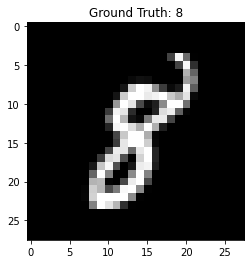

In [26]:
# lets grab something from the test set
import random
total_images = test_data_length # 10000
index = random.randint(0, total_images)
print("Random Test Image:", index)
count = 0
batch = index // test_kwargs["batch_size"]
batch_index = index % int(total_images / len(test_loader))
for tensor_ptr in test_loader:
    data, target = tensor_ptr[0], tensor_ptr[1]
    if batch == count:
        break
    count += 1

print(f"Displaying {index} == {batch_index} in Batch: {batch}/{len(test_loader)}")
image_1 = data[batch_index].reshape((28, 28))
label_1 = target[batch_index]
draw_image_and_label(image_1, label_1)

## Run Local model inference

In [27]:
# classify local
sy.logger.trace("Before running classify")
class_num, preds = classify_local(image_1)
print(f"Prediction: {class_num} Ground Truth: {label_1}")
print(preds)

1 <class 'torch.Tensor'>
2 <class 'torch.Tensor'>
3 <class 'torch.Tensor'>
Prediction: 8 Ground Truth: 8
tensor([1.9781e-05, 1.2030e-05, 3.8570e-05, 1.6585e-05, 2.9105e-06, 4.2355e-04,
        7.8849e-06, 2.1061e-06, 9.9940e-01, 7.7318e-05],
       grad_fn=<SqueezeBackward0>)


## Run Remote model inference

In [28]:
# classify remote
sy.logger.trace("Before running classify")
class_num, preds = classify(image_1)
print(f"Prediction: {class_num} Ground Truth: {label_1}")
print(preds)


> Waiting for Blocking Request
inference: To see a real world example of inference.
<UID:01e016e3-3172-48e9-839e-15ab9d71a293>

> INSIDE Request BLOCK 1.1920928955078125e-06 seconds False

> Blocking Request ACCEPTED
Prediction: 8 Ground Truth: 8
tensor([8.4406e-06, 1.8314e-05, 2.1068e-06, 3.2389e-06, 5.2382e-05, 5.4962e-05,
        1.4191e-06, 1.9418e-08, 9.9982e-01, 3.6174e-05],
       grad_fn=<SqueezeBackward0>)
